In [1]:
import pandas as pd
import requests
import json
from datetime import date, datetime
from time import sleep
import os
import codecs
from bs4 import BeautifulSoup
import statsmodels.api as sm
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression

In [2]:
cwd = os.getcwd()
f = open('output.txt', 'w')
f.close()

In [3]:
close = pd.read_csv(os.path.join(cwd, 'cm_close.csv'), index_col = 0)
supply = pd.read_csv(os.path.join(cwd, 'cm_supply.csv'), index_col = 0)
vol = pd.read_csv(os.path.join(cwd, 'cm_vol.csv'), index_col = 0)

print('closing prices')
print(close.head(5))
print('coins in circulation')
print(supply.head(5))
print('average daily vol')
print(vol.head(5))

closing prices
          Bitcoin Litecoin Peercoin Namecoin Terracoin     Devcoin Novacoin  \
20130428  $134.21    $4.35  $0.3865    $1.11   $0.6469  $0.0003261    $4.25   
20130505  $115.91    $3.59  $0.3037    $1.15    $0.568  $0.0002388    $3.69   
20130512  $115.00    $3.27  $0.2427  $0.8464   $0.3807  $0.0002208    $3.52   
20130519  $121.99    $3.30  $0.2074  $0.8576   $0.3587  $0.0002013    $3.62   
20130526  $133.48    $3.25  $0.1895  $0.9304   $0.3123  $0.0002016    $4.31   

         Feathercoin  Freicoin  Mincoin  ... Klaytn AscendEX (BitMax) Token  \
20130428         NaN       NaN      NaN  ...    NaN                     NaN   
20130505      $0.313  $0.08114  $0.1159  ...    NaN                     NaN   
20130512     $0.1253  $0.03596   $0.237  ...    NaN                     NaN   
20130519     $0.1269  $0.03416  $0.1952  ...    NaN                     NaN   
20130526    $0.09878   $0.0327  $0.1218  ...    NaN                     NaN   

         Pundi X[old] BTMX WazirX T

In [4]:
#convert into digits
def remove_non_digit(df):
    for c in df.columns:
        df.loc[:,c] = df.loc[:,c].str.replace(r'$', '',regex=False)
        df.loc[:,c] = df.loc[:,c].str.replace(r',',"", regex = False).astype(float)
    df.index = pd.to_datetime(df.index, format='%Y%m%d')
    return df

def remove_chars_supply(df):
    for c in df.columns:
        df.loc[:,c] = df.loc[:,c].str.replace("\D", '', regex = True)
        df.loc[:,c] = df.loc[:,c].str.replace(r'$', '',regex=False)
        df.loc[:,c] = df.loc[:,c].str.replace(r',',"", regex = False).astype(float)
    df.index = pd.to_datetime(df.index, format='%Y%m%d')
    return df

In [5]:
close = remove_non_digit(close)
print(close.head(5))
vol = remove_non_digit(vol)
print(vol.head(5))
supply = remove_chars_supply(supply)
print(supply.head(5))

            Bitcoin  Litecoin  Peercoin  Namecoin  Terracoin   Devcoin  \
2013-04-28   134.21      4.35    0.3865    1.1100     0.6469  0.000326   
2013-05-05   115.91      3.59    0.3037    1.1500     0.5680  0.000239   
2013-05-12   115.00      3.27    0.2427    0.8464     0.3807  0.000221   
2013-05-19   121.99      3.30    0.2074    0.8576     0.3587  0.000201   
2013-05-26   133.48      3.25    0.1895    0.9304     0.3123  0.000202   

            Novacoin  Feathercoin  Freicoin  Mincoin  ...  Klaytn  \
2013-04-28      4.25          NaN       NaN      NaN  ...     NaN   
2013-05-05      3.69      0.31300   0.08114   0.1159  ...     NaN   
2013-05-12      3.52      0.12530   0.03596   0.2370  ...     NaN   
2013-05-19      3.62      0.12690   0.03416   0.1952  ...     NaN   
2013-05-26      4.31      0.09878   0.03270   0.1218  ...     NaN   

            AscendEX (BitMax) Token  Pundi X[old]  BTMX  WazirX  The Sandbox  \
2013-04-28                      NaN           NaN   NaN     

In [6]:
#get the market capitalization
coin_cap = supply * close
#get returns
returns = close.pct_change()
returns = returns[close.notnull()]
returns = returns.dropna(axis = 1, how = 'all')

In [7]:
#form the mkt value weighted index

In [8]:
coin_cap = coin_cap.shift(1)
coin_cap = coin_cap.loc[returns.index, returns.columns]

In [9]:
def val_weighted_find(returns, coin_cap):
    val_weighted_index = pd.DataFrame()
    for ix, row in returns.iterrows():
        weights = coin_cap.loc[ix] / coin_cap.loc[ix].sum()
        val_weighted_index.loc[ix, 'index'] = (returns.loc[ix] * weights).sum()
    return val_weighted_index

<AxesSubplot:title={'center':'Cumlative Returns with Weekly Rebalancing'}>

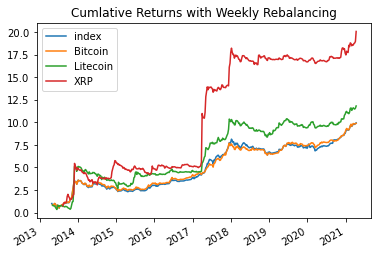

In [10]:
val_weighted_index = val_weighted_find(returns, coin_cap)

plot_ret = pd.concat([val_weighted_index, returns[['Bitcoin', 'Litecoin', 'XRP']]], axis = 1)
(plot_ret.cumsum() + 1.0).plot(title = 'Cumlative Returns with Weekly Rebalancing')

In [11]:
# can we explain bitcoin returns with index

In [12]:
X = val_weighted_index.copy()
Y = returns['Bitcoin']
X = sm.add_constant(X)
model = sm.OLS(Y,X, missing='drop')
res = model.fit(cov_type='HAC',cov_kwds={'maxlags':1})
print(res.summary())
f = open('output.txt', 'a')
f.write(res.summary().as_latex())
f.write('\n')
f.write('\n')
f.close()

                            OLS Regression Results                            
Dep. Variable:                Bitcoin   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     547.2
Date:                Wed, 14 Apr 2021   Prob (F-statistic):           2.26e-77
Time:                        15:13:00   Log-Likelihood:                 668.07
No. Observations:                 410   AIC:                            -1332.
Df Residuals:                     408   BIC:                            -1324.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.194      0.2

In [13]:
sign5 = 0
sign10 = 0
sign1 = 0
for i in returns.columns:
    X = val_weighted_index.copy()
    Y = returns.loc[:,i]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X, missing='drop')
    res = model.fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if res.pvalues['const'] < 0.05:
        sign5 = sign5 + 1
    if res.pvalues['const'] < 0.10:
        sign10 = sign10 + 1
    if res.pvalues['const'] < 0.01:
        sign1 = sign1 + 1

print('1 percent sig level')
print(sign1 / len(returns.columns))     
print('5 percent sig level')
print(sign5 / len(returns.columns))
print('10 percent sig level')
print(sign10 / len(returns.columns))

1 percent sig level
0.2081807081807082
5 percent sig level
0.2698412698412698
10 percent sig level
0.3418803418803419


# Form Rolling Features

In [14]:
def get_alpha(lookback, returns, factor_model):
    #initialize the alpha dataframe
    df_alpha = returns[lookback:].copy()
    #initialize the idiosyncratic volatility as well
    idiosyncratic_vol = returns[lookback:].copy()
    df_beta = returns[lookback:].copy()
    count = 0
    #iterate through the monthly data. At each point in time we find the insample alpha and idiosyncratic vol
    for ix, row in returns.iterrows(): 
        #check to make sure we have at least the lookback for analysis
        if count >= lookback:
            """
            note that python will not return the last part of the index. We want to by inclusive of this
            since this is an insample measure
            """
            analysis = returns[count-lookback:count]

            for ticker in returns.columns:
                if not analysis[ticker].isnull().values.any():
                    #the dependent variable is our security and index var is the independent var
                    y = pd.DataFrame(analysis[ticker], columns = [ticker])
                    # the index is your independent variable
                    x = factor_model.loc[y.index,:].copy()
                    #add a constant so we can get the alpha
                    x = sm.add_constant(x)

                    #use simple ols
                    mod = sm.OLS(y, x, missing='drop')
                    res = mod.fit()
                    #get the alpha
                    beta = res.params[factor_model.columns].values[0]
                    alpha = res.params['const']
                    #add the results to the alpha dataframe for analysis later
                    df_alpha.loc[ix, ticker] = alpha
                    df_beta.loc[ix, ticker] = beta
                    idiosyncratic_vol.loc[ix, ticker] = res.resid.std()
                else:
                    df_alpha.loc[ix, ticker] = np.nan
                    df_beta.loc[ix, ticker] = np.nan
                    idiosyncratic_vol.loc[ix, ticker] = np.nan
                    

        #iterate to the next point in our data
        count = count + 1

    #notice that I populated the alpha and idiosyncratic volatility with the full returns dataframe. 
    #these two lines remove the lookback period for clean reading
    df_alpha = df_alpha.dropna(axis = 0, how = 'all')
    idiosyncratic_vol = idiosyncratic_vol.dropna(axis = 0, how = 'all')
    df_beta = df_beta.dropna(axis = 0, how = 'all')

    return df_alpha, idiosyncratic_vol, df_beta, analysis

In [15]:
alpha, idiosyncratic, beta, analysis = get_alpha(52, returns, val_weighted_index)

In [16]:
features = {}
features['Yearly Momentum'] = (returns.rolling(52,min_periods=52).sum()).dropna(how = 'all', axis = 1).dropna(how = 'all', axis = 0)
features['Monthly Momentum'] = (returns.rolling(4,min_periods =4).sum()).dropna(how = 'all', axis = 1).dropna(how = 'all', axis = 0)

features['Yearly Volatility'] = (returns.rolling(52,min_periods=52).std()).dropna(how = 'all', axis = 1).dropna(how = 'all', axis = 0)

features['Yearly Sharpe'] = (returns.rolling(52, min_periods = 52).mean() / returns.rolling(52, min_periods = 52).std()).dropna(how = 'all', axis = 1).dropna(how = 'all', axis = 0)

features['Yearly Skew']= (returns.rolling(52, min_periods = 52).skew()).dropna(how = 'all', axis = 1).dropna(how = 'all', axis = 0)

features['Monthly Max'] = (returns.rolling(4, min_periods = 4).max()).dropna(how = 'all', axis = 1).dropna(how = 'all', axis = 0)

features['Yearly Median Return'] = (returns.rolling(252, min_periods = 252).median()).dropna(how = 'all', axis = 1).dropna(how = 'all', axis = 0)

features['Alpha'] = alpha
features['Beta'] = beta
features['Idiosyncratic Volatility'] = idiosyncratic



In [17]:
def t_test(x ,null):
    tt= (x.mean() - null) / (x.std()/ np.sqrt(len(x.index)))
    p = stats.t.sf(np.abs(tt), len(x.index)-1)*2
    return tt, p
        
    

In [97]:
def get_factor_model(r,val_weighted_index):
    y = r.copy()
    y.columns = ['strategy']
    # the index is your independent variable
    x = val_weighted_index.loc[r.index,:].copy()
    #add a constant so we can get the alpha
    x = sm.add_constant(x)

    #use simple ols
    mod = sm.OLS(y, x.astype(float), missing='drop')
    res = mod.fit()
    #get the alpha
    beta = res.params['index']
    alpha = res.params['const']
    p_beta = res.pvalues['index']
    p_alpha = res.pvalues['const']
    return alpha, p_alpha, beta, p_beta

# Quintiles

In [53]:
port_eql_results = {}
port_val_results = {}

print('Port 5 is the highest')
for k in features.keys():
    features[k] = features[k][features[k].index.year > 2015]
    port_eql_results[k] = {}
    port_val_results[k] = {}

    #rank cross sectionally
    features_ranking= features[k].shift(1).dropna(how = 'all').rank(axis = 1, pct = True, ascending = False)
    r_map = returns.loc[features_ranking.index, features_ranking.columns]
    c_map = coin_cap.loc[features_ranking.index, features_ranking.columns]

    null_ret = 0.0

    r = r_map[features_ranking <= .2].mean(axis = 1)
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = pd.DataFrame(r, columns = ['index']) - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_eql_results[k]['Port 1'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]

    r = r_map[(features_ranking >.2) & (features_ranking <= .4)].mean(axis = 1)
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = pd.DataFrame(r, columns = ['index']) - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_eql_results[k]['Port 2'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]

    r = r_map[(features_ranking >.4) & (features_ranking <= .6)].mean(axis = 1)
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = pd.DataFrame(r, columns = ['index']) - val_weighted_index.loc[r.index]
    t,p = t_test(r ,null_ret)
    port_eql_results[k]['Port 3'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]

    r = r_map[(features_ranking >.6) & (features_ranking <= .8)].mean(axis = 1)
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = pd.DataFrame(r, columns = ['index']) - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_eql_results[k]['Port 4'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]

    r = r_map[(features_ranking >.8) & (features_ranking <= 1.0)].mean(axis = 1)
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = pd.DataFrame(r, columns = ['index']) - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_eql_results[k]['Port 5'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]

    ########### get the value weighted ########################################################3

    r = val_weighted_find(r_map[(features_ranking <= .2)], c_map[r_map[(features_ranking <= .2)].notnull()])
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = r - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_val_results[k]['Port 1'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]

    r = val_weighted_find(r_map[(features_ranking >.2) & (features_ranking <= .4)], c_map[r_map[(features_ranking >.2) & (features_ranking <= .4)].notnull()])
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = r - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_val_results[k]['Port 2'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]

    r = val_weighted_find(r_map[(features_ranking >.4) & (features_ranking <= .6)], c_map[r_map[(features_ranking >.4) & (features_ranking <= .6)].notnull()])
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = r - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_val_results[k]['Port 3'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]

    r = val_weighted_find(r_map[(features_ranking >.6) & (features_ranking <= .8)], c_map[r_map[(features_ranking >.6) & (features_ranking <= .8)].notnull()])
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = r - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_val_results[k]['Port 4'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]

    r = val_weighted_find(r_map[(features_ranking >.8) & (features_ranking <= 1.0)], c_map[r_map[(features_ranking >.8) & (features_ranking <= 1.0)].notnull()])
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = r - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_val_results[k]['Port 5'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]

for k in port_eql_results.keys():
    print('Equal Weighted: ' + k)
    port_eql_results[k] = pd.DataFrame.from_dict(port_eql_results[k], orient = 'index')
    port_eql_results[k].columns = ['Return', 't-stat', 'p-value','Alpha','p-value Alpha', 'Beta', 'p-value Beta']
    port_eql_results[k] = round(port_eql_results[k],2)
    print(port_eql_results[k])

    print(' ')
    print(' ')
    print('Value Weighted: ' + k)
    port_val_results[k] = pd.DataFrame.from_dict(port_val_results[k], orient = 'index')
    port_val_results[k].columns = ['Return', 't-stat', 'p-value','Alpha','p-value Alpha', 'Beta', 'p-value Beta']
    port_val_results[k] = round(port_val_results[k],2)
    print(port_val_results[k])

    print(' ')
    print(' ')

Port 5 is the highest
Equal Weighted: Yearly Momentum
        Return  t-stat  p-value  Alpha  p-value Alpha  Beta  p-value Beta
Port 1    0.70    1.00     0.32   0.01           0.32  0.99           0.0
Port 2    1.14    1.47     0.14   0.01           0.22  1.06           0.0
Port 3    1.04    1.72     0.09   0.01           0.09  0.99           0.0
Port 4    1.35    1.88     0.06   0.01           0.14  1.10           0.0
Port 5    0.72    1.08     0.28   0.01           0.12  0.87           0.0
 
 
Value Weighted: Yearly Momentum
        Return  t-stat  p-value  Alpha  p-value Alpha  Beta  p-value Beta
Port 1    0.96    1.01     0.31   0.01           0.49  1.11           0.0
Port 2    0.70    0.76     0.45   0.01           0.41  0.97           0.0
Port 3   -0.07   -0.14     0.89   0.00           0.89  0.94           0.0
Port 4    0.33    0.53     0.60   0.01           0.40  0.92           0.0
Port 5    0.43    0.34     0.73   0.01           0.50  0.83           0.0
 
 
Equal Weighted: Mo

In [54]:
round(port_val_results[k],2)

,Return,t-stat,p-value,Alpha,p-value Alpha,Beta,p-value Beta
Port 1,0.82,0.78,0.44,0.00,0.67,1.14,0.0
Port 2,0.92,1.13,0.26,0.01,0.27,1.00,0.0
Port 3,1.81,1.53,0.13,0.01,0.25,1.16,0.0
Port 4,0.56,0.84,0.40,0.01,0.39,0.99,0.0
Port 5,-0.15,-0.43,0.67,0.00,0.34,0.82,0.0


# Quartiles

In [55]:
port_eql_results = {}
port_val_results = {}

print('Port 4 is the highest')
for k in features.keys():
    #features[k] = features[k][features[k].index.year > 2015]
    port_eql_results[k] = {}
    port_val_results[k] = {}
    
    #rank cross sectionally
    features_ranking= features[k].shift(1).dropna(how = 'all').rank(axis = 1, pct = True, ascending = False)
    r_map = returns.loc[features_ranking.index, features_ranking.columns]
    c_map = coin_cap.loc[features_ranking.index, features_ranking.columns]
    
    null_ret = 0.0
    
    r = r_map[features_ranking <= .25].mean(axis = 1)
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = pd.DataFrame(r, columns = ['index']) - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_eql_results[k]['Port 1'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]
    
    r = r_map[(features_ranking >.25) & (features_ranking <= .5)].mean(axis = 1)
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = pd.DataFrame(r, columns = ['index']) - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_eql_results[k]['Port 2'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]
    
    r = r_map[(features_ranking >.5) & (features_ranking <= .75)].mean(axis = 1)
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = pd.DataFrame(r, columns = ['index']) - val_weighted_index.loc[r.index]
    t,p = t_test(r ,null_ret)
    port_eql_results[k]['Port 3'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]
    
    r = r_map[(features_ranking >.75) & (features_ranking <= 1.0)].mean(axis = 1)
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = pd.DataFrame(r, columns = ['index']) - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_eql_results[k]['Port 4'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]
    
    ########### get the value weighted ########################################################3
    
    r = val_weighted_find(r_map[(features_ranking <= .25)], c_map[r_map[(features_ranking <= .25)].notnull()])
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = r - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_val_results[k]['Port 1'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]
    
    r = val_weighted_find(r_map[(features_ranking >.25) & (features_ranking <= .5)], c_map[r_map[(features_ranking >.25) & (features_ranking <= .5)].notnull()])
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = r - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_val_results[k]['Port 2'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]
    
    r = val_weighted_find(r_map[(features_ranking >.5) & (features_ranking <= .75)], c_map[r_map[(features_ranking >.5) & (features_ranking <= .75)].notnull()])
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = r - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_val_results[k]['Port 3'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]
    
    r = val_weighted_find(r_map[(features_ranking >.75) & (features_ranking <= 1.0)], c_map[r_map[(features_ranking >.75) & (features_ranking <= 1.0)].notnull()])
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = r - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_val_results[k]['Port 4'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]
    

for k in port_eql_results.keys():
    print('Equal Weighted: ' + k)
    port_eql_results[k] = pd.DataFrame.from_dict(port_eql_results[k], orient = 'index')
    port_eql_results[k].columns = ['Return', 't-stat', 'p-value','Alpha','p-value Alpha', 'Beta', 'p-value Beta']
    port_eql_results[k] = round(port_eql_results[k],2)
    print(port_eql_results[k])
    
    print(' ')
    print(' ')
    print('Value Weighted: ' + k)
    port_val_results[k] = pd.DataFrame.from_dict(port_val_results[k], orient = 'index')
    port_val_results[k].columns = ['Return', 't-stat', 'p-value','Alpha','p-value Alpha', 'Beta', 'p-value Beta']
    port_val_results[k] = round(port_val_results[k],2)
    print(port_val_results[k])

    print(' ')
    print(' ')

Port 4 is the highest
Equal Weighted: Yearly Momentum
        Return  t-stat  p-value  Alpha  p-value Alpha  Beta  p-value Beta
Port 1    0.89    1.28     0.20   0.01           0.28  1.04           0.0
Port 2    1.30    2.03     0.04   0.01           0.06  1.02           0.0
Port 3    0.62    1.07     0.28   0.01           0.31  1.01           0.0
Port 4    1.06    1.47     0.14   0.01           0.09  0.93           0.0
 
 
Value Weighted: Yearly Momentum
        Return  t-stat  p-value  Alpha  p-value Alpha  Beta  p-value Beta
Port 1    0.81    0.88     0.38   0.01           0.58  1.11           0.0
Port 2    0.46    0.69     0.49   0.01           0.36  0.94           0.0
Port 3    0.22    0.43     0.67   0.00           0.55  0.96           0.0
Port 4    0.38    0.33     0.74   0.01           0.51  0.85           0.0
 
 
Equal Weighted: Monthly Momentum
        Return  t-stat  p-value  Alpha  p-value Alpha  Beta  p-value Beta
Port 1    1.58    2.25     0.03   0.02           0.02  0.98

# Triplets

In [58]:
port_eql_results = {}
port_val_results = {}

print('Quartile 3 is the highest')
for k in features.keys():
    #features[k] = features[k][features[k].index.year > 2015]
    port_eql_results[k] = {}
    port_val_results[k] = {}
    
    #rank cross sectionally
    features_ranking= features[k].shift(1).dropna(how = 'all').rank(axis = 1, pct = True, ascending = False)
    r_map = returns.loc[features_ranking.index, features_ranking.columns]
    c_map = coin_cap.loc[features_ranking.index, features_ranking.columns]
    
    null_ret = 0.0
    
    r = r_map[features_ranking <= .33].mean(axis = 1)
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = pd.DataFrame(r, columns = ['index']) - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_eql_results[k]['Port 1'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]
    
    r = r_map[(features_ranking >.33) & (features_ranking <= .66)].mean(axis = 1)
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = pd.DataFrame(r, columns = ['index']) - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_eql_results[k]['Port 2'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]
    
    r = r_map[(features_ranking >.66) & (features_ranking <= 1.0)].mean(axis = 1)
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = pd.DataFrame(r, columns = ['index']) - val_weighted_index.loc[r.index]
    t,p = t_test(r ,null_ret)
    port_eql_results[k]['Port 3'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]
    

    ########### get the value weighted ########################################################3
    
    r = val_weighted_find(r_map[(features_ranking <= .33)], c_map[r_map[(features_ranking <= .33)].notnull()])
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = r - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_val_results[k]['Port 1'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]
    
    r = val_weighted_find(r_map[(features_ranking >.33) & (features_ranking <= .66)], c_map[r_map[(features_ranking >.33) & (features_ranking <= .66)].notnull()])
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = r - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_val_results[k]['Port 2'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]
    
    r = val_weighted_find(r_map[(features_ranking >.66) & (features_ranking <= 1.0)], c_map[r_map[(features_ranking >.66) & (features_ranking <= 1.0)].notnull()])    
    a, p_alpha, b, p_beta = get_factor_model(r,val_weighted_index)
    r = r - val_weighted_index.loc[r.index]
    t,p = t_test(r,null_ret)
    port_val_results[k]['Port 3'] = [round(r.mean().values[0]*100.0,2),t.values[0],p[0],a, p_alpha, b, p_beta]
    

for k in port_eql_results.keys():
    print('Equal Weighted: ' + k)
    port_eql_results[k] = pd.DataFrame.from_dict(port_eql_results[k], orient = 'index')
    port_eql_results[k].columns = ['Return', 't-stat', 'p-value','Alpha','p-value Alpha', 'Beta', 'p-value Beta']
    port_eql_results[k] = round(port_eql_results[k],2)
    print(port_eql_results[k])
    f = open('output.txt', 'a')
    f.write(r'\begin{table}[H]')
    f.write('\n')
    f.write(r'\caption{\: ' + 'Equal Weighted: ' + k + r'}')
    f.write(port_eql_results[k].to_latex())
    f.write(r'\end{table}')
    f.write('\n')
    f.write('\n')
    f.close()
    
    print(' ')
    print(' ')
    print('Value Weighted: ' + k)
    port_val_results[k] = pd.DataFrame.from_dict(port_val_results[k], orient = 'index')
    port_val_results[k].columns = ['Return', 't-stat', 'p-value','Alpha','p-value Alpha', 'Beta', 'p-value Beta']
    port_val_results[k] = round(port_val_results[k],2)
    print(port_val_results[k])
    f = open('output.txt', 'a')
    f.write(r'\begin{table}[H]')
    f.write('\n')
    f.write(r'\caption{\: ' + 'Value Weighted: ' + k + r'}')
    f.write(port_val_results[k].to_latex())
    f.write(r'\end{table}')
    f.write('\n')
    f.write('\n')
    f.close()
    print(' ')
    print(' ')

Quartile 3 is the highest
Equal Weighted: Yearly Momentum
        Return  t-stat  p-value  Alpha  p-value Alpha  Beta  p-value Beta
Port 1    0.83    1.27     0.20   0.01           0.25  1.03           0.0
Port 2    1.05    1.77     0.08   0.01           0.08  0.99           0.0
Port 3    1.04    1.60     0.11   0.01           0.11  0.98           0.0
 
 
Value Weighted: Yearly Momentum
        Return  t-stat  p-value  Alpha  p-value Alpha  Beta  p-value Beta
Port 1    0.56    0.66     0.51    0.0           0.67  1.07           0.0
Port 2    0.05    0.11     0.91    0.0           0.66  0.94           0.0
Port 3   -0.61   -1.32     0.19    0.0           0.90  0.74           0.0
 
 
Equal Weighted: Monthly Momentum
        Return  t-stat  p-value  Alpha  p-value Alpha  Beta  p-value Beta
Port 1    1.50    2.30     0.02   0.02           0.02  0.98           0.0
Port 2    1.28    2.20     0.03   0.01           0.04  1.01           0.0
Port 3    6.03    1.28     0.20   0.03           0.47  

# Sentiment Indicators

In [59]:
class MessageData():
    def __init__(self):
        self.wd = os.getcwd()
    
    def get_message(self):
        message_direc = os.path.join(self.wd, 'message_data')
        subdirec = [x[0] for x in os.walk(message_direc)]
        text_data = {}
        
        for s in subdirec:
            subdirec_files = [x[2] for x in os.walk(os.path.join(message_direc, s))]
            text_data[s] = subdirec_files[0]
            document_combined = []
            for t in text_data[s]:
                f = codecs.open(os.path.join(message_direc, s, t), 'r', 'utf-8')
                document= BeautifulSoup(f.read()).get_text()
                document = document.split('\n')
                document = [x.strip() for x in document if x.strip()]
                document_combined = document_combined + document
                
            with open(os.path.join(self.wd, 'cleaned_message_data', s.split('/')[-1]+'.txt'), 'w') as f:
                for item in document_combined:
                    f.write("%s\n" % item)
            
        return document_combined, s
    
    def get_text_ts(self):
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        daily_f = os.listdir(os.path.join(os.getcwd(), 'cleaned_message_data'))
        
        word_vec_dict = {}
        for f in daily_f:
            word_vec_dict[f] = {}
            cur_date = ''
            
            file1 = open(os.path.join(os.getcwd(), 'cleaned_message_data',f), 'r')
            lines = file1.readlines()
            for line in lines:
                if 'Next message' not in line:
                    cleaned_line = line.replace('\n','')
                    #cleaned_line = cleaned_line.lower()
                    
                    isdate = False
                    for  m in months:
                        if m in cleaned_line and cleaned_line[-4:].isdigit() and cleaned_line[0].isdigit() and cleaned_line[-5] == ' ' and len(cleaned_line.split(' ')) == 3:
                            isdate = True
                    if isdate:
                        cur_date = pd.to_datetime(cleaned_line)
                        if cur_date not in word_vec_dict[f].keys():
                            word_vec_dict[f][cur_date] = {}
                    else:
                        if cur_date != '':
                            cleaned_line = cleaned_line.lower()
                            alphanumeric = ""
                            for character in cleaned_line:
                                if character.isalpha() or character == ' ':
                                    alphanumeric += character
                            words = alphanumeric.split(' ')
                            for w in words:
                                w = w.strip()
                                if w not in word_vec_dict[f][cur_date].keys():
                                    word_vec_dict[f][cur_date][w] = 1
                                else:
                                    word_vec_dict[f][cur_date][w] = 1 + word_vec_dict[f][cur_date][w]
        #get the text vectors for each message board
        txt_panel = {}
        for k in word_vec_dict.keys():
            txt_panel[k] = pd.DataFrame()
            for d in word_vec_dict[k].keys():
                word_vec = pd.DataFrame.from_dict(word_vec_dict[k][d], orient = 'index')
                word_vec.columns = [d]
                add = word_vec.T
                if txt_panel[k].empty:
                    txt_panel[k] = add.copy()
                else:
                    txt_panel[k] = pd.concat([txt_panel[k], add], axis = 0)
            txt_panel[k] = txt_panel[k].sort_index()
            txt_panel[k].to_csv(os.path.join(os.getcwd(), 'message_data_word_vec',k.replace('.txt','.csv')))
        
        #get the text vectors of all message boards
        all_panel = pd.DataFrame()
        for p in txt_panel.keys():
            if all_panel.empty:
                all_panel = txt_panel[p].copy()
            else:
                for c in txt_panel[p].columns:
                    if c in all_panel.columns:
                        all_panel[c] = all_panel[c] + txt_panel[p][c]
                    else:
                        all_panel = pd.concat([all_panel, txt_panel[p][c]], axis = 1)
                
        return txt_panel, all_panel

In [193]:
md = MessageData()
md.get_message()
txt_panel, all_txt = md.get_text_ts()


KeyboardInterrupt: 

In [262]:
stopwords = pd.read_csv('StopWords_Generic.txt')
stop = stopwords.values.tolist()
stoplist = []
for i in stop:
    stoplist.append(i[0].lower())
print(stoplist)
stoplist = stoplist  + ['altcenter','signals','pig','settings','export', 'download']
for p in txt_panel.keys():
    new_cols = []
    for col in txt_panel[p].columns:
        if col not in stoplist and len(col) > 2:
            new_cols.append(col)
    txt_panel[p] = txt_panel[p].loc[:, new_cols]

['above', 'after', 'again', 'all', 'am', 'among', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'did', 'do', 'does', 'doing', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'just', 'me', 'more', 'most', 'my', 'myself', 'no', 'nor', 'not', 'now', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', 'she', 'should', 'so', 'some', 'such', 'than', 'that', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'with', 'you', 'your', 'yours', 'yourself', 'yourselves']


In [269]:
all_panel = pd.DataFrame()
sentiment_list = ['gang','pump', 'takeprofit','bitcoins','legit','bitcoin','profit','btc','invest','investment','buy']
for p in txt_panel.keys():
    try:
        print(txt_panel[p].sum().sort_values(ascending = False)[0:25])
        add = txt_panel[p][txt_panel[p].columns[txt_panel[p].columns.isin(sentiment_list)]].sum(axis = 1)
        add = pd.DataFrame(add)
        add.columns = [p.replace('.txt','')]
        if all_panel.empty:
            all_panel = add.copy()
        else:
            all_panel = pd.concat([all_panel, add], axis = 1)
    except:
        pass

bitcoin      2899.0
trading      2693.0
crypto       2684.0
data          895.0
change        881.0
photo         880.0
included      880.0
exporting     880.0
message       603.0
reply         592.0
will          407.0
buying        351.0
btc           278.0
buy           195.0
profit        174.0
time          167.0
pump          166.0
far           155.0
binance       140.0
target        124.0
next          113.0
support       112.0
price         110.0
new           109.0
dip           108.0
dtype: float64
Series([], dtype: float64)
fat           4155.0
gang          1624.0
plank         1616.0
vip           1112.0
service        888.0
target         848.0
dad            730.0
message        698.0
profit         645.0
takeprofit     601.0
period         573.0
minutes        567.0
reply          560.0
hours          552.0
data           423.0
included       405.0
change         403.0
exporting      397.0
days           396.0
will           387.0
photo          379.0
update         34

In [289]:
s = txt_panel[p].sum()
txt_panel[p][s.sort_values(ascending=False).index[:2]]

,bitcoin,one
2018-01-10,2,NaN
2018-02-22,2,NaN
2020-08-21,11,NaN
2020-09-02,1,NaN
2020-09-04,1,NaN
2020-09-05,2,1.0
2020-09-08,1,NaN
2020-09-10,4,NaN
2020-09-11,1,1.0
2020-09-15,3,NaN


AxesSubplot(0.125,0.2;0.775x0.68)


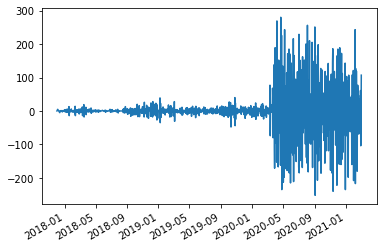

In [290]:
btc = all_panel.sum(axis = 1)
btc_z = (btc.rolling(1).sum() - btc.rolling(1).sum().shift(1)).shift(1)
btc_z.dropna()
print(btc_z.plot())

<AxesSubplot:>

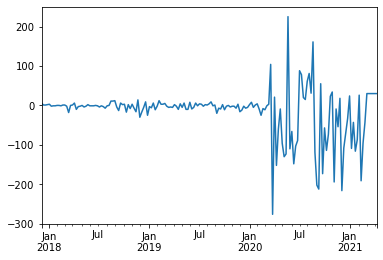

In [291]:
sentiment['sentiment'].plot()

In [292]:
sentiment = pd.concat([btc_z, val_weighted_index], axis = 1)
sentiment.columns = ['sentiment', 'index']
sentiment['sentiment'] = sentiment['sentiment'].fillna(method='ffill')
sentiment = sentiment.dropna()

strategy = sentiment['index'].copy()
strategy = pd.DataFrame(strategy)
strategy.columns = ['strategy']

strategy.loc[sentiment['sentiment'] >= 0, 'strategy'] = 0.0
X = val_weighted_index.loc[strategy.index].copy()
Y = strategy.copy()
X['constant'] = 1.0
model = sm.OLS(Y,X, missing='drop')
res = model.fit(cov_type='HAC',cov_kwds={'maxlags':1})
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               strategy   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     39.94
Date:                Thu, 15 Apr 2021   Prob (F-statistic):           2.12e-09
Time:                        08:05:53   Log-Likelihood:                 239.88
No. Observations:                 176   AIC:                            -475.8
Df Residuals:                     174   BIC:                            -469.4
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
index          0.4973      0.079      6.320      0.0

<AxesSubplot:>

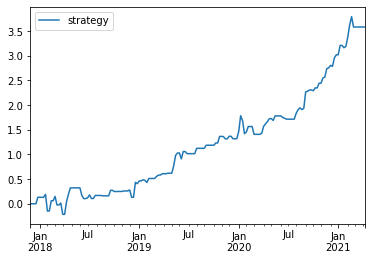

In [294]:
strategy.cumsum().plot()